Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

#### Load Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import time
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier

## Section 1: Business Understanding 1

The data set we selected is a compilation of horse racing data. The goal is to create a machine learning model that is able to predict both winners and placers in individual horse races by providing different metrics about horses in each race. Our goal in looking at this data is to build a model that would maximize the chance of picking a winning horse while also minimizing the number of false positives. For this reason, we want to look at two different metrics to determine if a model is successful, precision and AUC. Since precision is a measure of true positives to false positives it allows us to understand the confidence with which we can place a bet at the races. We also are looking at AUC as a metric as well, because only 1 out of every 14 horses will win and 3 out of 14 will place. This means that the data set is very unbalanced, and we have to take that into account when building our models. Looking at AUC allows us to know how well the model is handling this. Is it predicting everyone will lose or is it attempting to pick winners as well? A model with 90% accuracy is great but if it doesn’t predict a single winner, the model is useless. AUC will help us to keep a balance. When handing this data set to stakeholders explaining precision is very similar to what they will understand dealing with win odds and place odds, so it is a good metric to use. For looking specifically at our cluster performance, we will be using Silhouette score to judge these. This metrics looks at how defined each cluster is and rates it on a score of -1(less defined) to 1 (perfectly defined). Once we have determined the best cluster method we will be testing whether adding those clusters to the model improves our original metrics of Precision and AUC.

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

### Sub-Section 2.1: Load Data

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


### Sub-Section 2.2: Describe the Data

In [4]:
#First column (index 0) hidden because it represents the physical row location and doesn't have contextual meaning
print('Data File Shape:', runs_df.iloc[:,1:].shape,'\n')
runs_df.iloc[:,1:].info()
runs_df.iloc[:,1:].describe()

Data File Shape: (79423, 29) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   race_id          79423 non-null  int64  
 1   horse_no         79423 non-null  int64  
 2   horse_id         79423 non-null  int64  
 3   result           79423 non-null  int64  
 4   won              79423 non-null  float64
 5   lengths_behind   79423 non-null  float64
 6   horse_age        79423 non-null  int64  
 7   horse_country    79423 non-null  object 
 8   horse_type       79423 non-null  object 
 9   horse_rating     79423 non-null  int64  
 10  horse_gear       79423 non-null  object 
 11  declared_weight  79423 non-null  float64
 12  actual_weight    79423 non-null  int64  
 13  draw             79423 non-null  int64  
 14  position_sec1    79423 non-null  int64  
 15  position_sec2    79423 non-null  int64  
 16  position_sec3    79423 non-

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,declared_weight,actual_weight,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.00000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,3173.954132,6.905644,2204.346159,6.837050,0.080078,5.858119,3.339461,61.035103,1104.952609,122.730091,...,4.246243,21.12304,22.916673,23.850489,85.325614,28.806138,7.421841,79.794379,85.832983,0.240069
std,1832.807523,3.760600,1275.090631,3.729836,0.271415,29.721938,0.876864,11.750531,62.350596,6.305551,...,3.482293,5.99998,0.982845,0.877137,18.511937,30.093854,8.613459,45.118550,54.338459,0.427128
min,0.000000,1.000000,0.000000,1.000000,0.000000,-0.500000,2.000000,10.000000,693.000000,103.000000,...,0.000000,12.39000,19.990000,21.000000,55.160000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1587.000000,4.000000,1085.000000,4.000000,0.000000,1.750000,3.000000,60.000000,1062.000000,118.000000,...,1.750000,14.12000,22.290000,23.230000,70.590000,7.700000,2.400000,47.000000,39.000000,0.000000
50%,3175.000000,7.000000,2209.000000,7.000000,0.000000,4.000000,3.000000,60.000000,1102.000000,123.000000,...,3.750000,24.18000,22.870000,23.760000,83.350000,15.000000,4.400000,75.000000,76.000000,0.000000
75%,4765.000000,10.000000,3308.000000,10.000000,0.000000,6.750000,3.000000,60.000000,1146.000000,128.000000,...,5.750000,25.36000,23.520000,24.410000,100.780000,38.000000,8.200000,118.000000,138.000000,0.000000
max,6348.000000,14.000000,4404.000000,14.000000,1.000000,999.000000,10.000000,138.000000,1369.000000,133.000000,...,206.750000,33.20000,27.410000,54.950000,163.580000,99.000000,101.000000,175.000000,185.000000,1.000000


The data file contains 29 attributes (28 provided and 1 created) and 79,423 instances. The response variable for our classifications will be the 'Won' attribute. The descriptive statistics for each predictor are listed above. We do not see any missing values or any values outside of a reasonable range of outcomes. Therefore, we do not need to impute any missing values or evaluate trimming instances with outlier values.

First, we will describe the response variable we are focused on classifying.

Response Variable:
- Won: a boolean value where 1 indicates the horse finished first in the race and 0 indicates the horse did not. A horse with a Result of 1 will have a Won response of 1. All others will have a Won response of 0.

Next, we will trim down features that leak information about the response variable, and remove features that don't provide useful insight based on our team's domain knowledge and previous investigations.

Features to be removed because they leak information about the outcome that would not normally be available before a race:
- result: finishing position of this horse in the race
- lengths_behind: finishing position, as the number of horse lengths behind the winner
- position_sec1/2/3: position of this horse (ranking) in section 1/2/3 of the race
- behind_sec1/2/3: position of this horse (lengths behind leader) in section 1/2/3 of the race
- time1/2/3: time taken by the horse to pass through the 1st/2nd/3rd section of the race (sec)
- finish_time: finishing time of the horse in this race (sec)
- Show: a boolean value where 1 indicates the horse placed in the top 3 of the race and 0 indicates the horse did not. A horse with a Result of 1, 2, or 3 will have a Show response of 1. All others will have a Show response of 0.
    - Show is the one created variable that is included with the initial data because it is a common wager placed by horse racing gamblers

Features to be removed because they do not provide sufficient insight about the response:
- race_id: unique identifier for the race
- horse_id: unique identifier for this horse
- horse_gear: string representing the gear carried by the horse in the race. An explanation of the codes used may be found on the HKJC website
- trainer_id: unique identifier of the horse's trainer at the time of the race
- jockey_id: unique identifier of the jockey riding the horse in this race

Now, we will define the remaining continuous and categorical features that will be used to create clusters and classify the response. The 2 categorical features will be one-hot encoded where each categorical level will become a binary feature with outcomes of 0 or 1. This will result in 8 continuous features and 25 binary features remaining. Due to the variance of scale in the remaining features, our team will use a MinMax Scaler before classification. This scales each feature based on the relative position of each value between the min and max values of the feature. During this scaling, we will ensure we limit data leakage by fitting the scale to the training data and transforming both the training and testing data based on the fit. (Train/test split strategy will be discussed in a later section)

Continuous features:
- Horse_no: the number assigned to this horse, in the race
- Horse_age: all horses in the data set are 2, 3, 4, 5, 6, 7, 8, 9, or 10 years old at the time of race. The average age of horses in the dataset is 3.3 years
- Horse_rating - rating number assigned by HKJC to this horse at the time of the race
- Declared_weight: floating point value for the weight of the horse, the jockey, and the equipment in pounds.
- Actual_weight: integer value for the weight the horse carried; i.e. the weight of the Jockey and equipment
- Draw - post position number of the horse in this race
- Win_odds: floating point value for the odds of the horse to win the race
- Place_odds: floating point value for the odds of the horse to place in 1st, 2nd, or 3rd

Categorical features that will be one-hot encoded:
- Horse_country: a country code for the country of origin for the horse. Examples are NZ, AUS, USA
- Horse_type: examples are gelding, mare, rig

### Sub-Section 2.3: Remove uneeded features and one-hot encode categorical data

#### Remove variables that are not needed/useful for the analysis

In [5]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [6]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
print('Won Response Set Shape: ',runs_target.shape)
print('Show Response Set Shape: ',runs_target2.shape)
runs_data.info()
runs_data.describe()

Won Response Set Shape:  (79423,)
Show Response Set Shape:  (79423,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            79423 non-null  int64  
 1   horse_age           79423 non-null  int64  
 2   horse_rating        79423 non-null  int64  
 3   declared_weight     79423 non-null  float64
 4   actual_weight       79423 non-null  int64  
 5   draw                79423 non-null  int64  
 6   win_odds            79423 non-null  float64
 7   place_odds          79423 non-null  float64
 8   horse_country_ARG   79423 non-null  uint8  
 9   horse_country_AUS   79423 non-null  uint8  
 10  horse_country_BRZ   79423 non-null  uint8  
 11  horse_country_CAN   79423 non-null  uint8  
 12  horse_country_FR    79423 non-null  uint8  
 13  horse_country_GB    79423 non-null  uint8  
 14  horse_country_GER   79423 non-nul

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,6.905644,3.339461,61.035103,1104.952609,122.730091,6.875729,28.806138,7.421841,0.001599,0.376415,...,0.000151,0.025736,0.003840,0.000541,0.950367,0.000214,0.013762,0.002997,0.001939,0.000604
std,3.760600,0.876864,11.750531,62.350596,6.305551,3.747588,30.093854,8.613459,0.039956,0.484489,...,0.012291,0.158346,0.061851,0.023262,0.217187,0.014629,0.116501,0.054660,0.043991,0.024576
min,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,60.000000,1062.000000,118.000000,4.000000,7.700000,2.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,15.000000,4.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,3.000000,60.000000,1146.000000,128.000000,10.000000,38.000000,8.200000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,99.000000,101.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#Not using K-fold cv for base models of clustering this will only be used for Adaboost model and random forest comparison
cv = StratifiedKFold(n_splits = 10, shuffle = True ,random_state = 0)

In [9]:
#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#train test split place
X_train_place,X_test_place,Y_train_place,Y_test_place = train_test_split(runs_data,runs_target2,test_size=0.20,random_state=0)
X_train_place = mmscl_obj.fit_transform(X_train_place,y = None)
X_test_place = mmscl_obj.transform(X_test_place)

## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

#### Win Odds and Horse Country

The following graph plots the country of origin for the horse and its win odds. There is some relationship between a horse's country of origin and its win odds. Particularly, horses from Australia and New Zealand tend to have really good odds. Horses from Canada, Italy, Argentina tend to have lower odds but also a wider distribution.

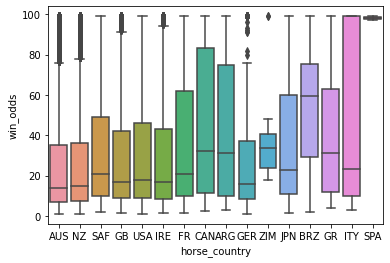

In [10]:
sns.boxplot(x="horse_country",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Horse Type

Next, we looked at horse type, which based on previous labs tended to be an important feature. Geldings, Browns, and Greys had smaller distributions of win odds. Geldings had the best odds on average. Rigs, Colts, and Fillys would be less sure bets based on the distribution of odds for those types of horses.

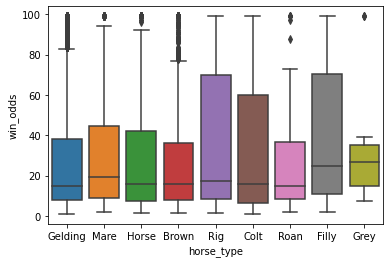

In [11]:
sns.boxplot(x="horse_type",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Finish Place

Based on previous labs, far and away the most important feature in determining a result was the horse's win odds. The graph below plots that relationship. As can be seen, there is a strong relationship. Horses with better odds were not only more likely to win (based on mean) but had much smaller distributions. Intuitively, this makes sense. Horse odds are set by professionals who have the best information and insight into the chances a horse will win a particular race.

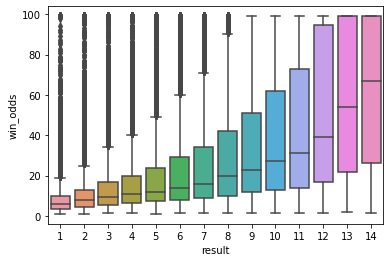

In [12]:
sns.boxplot(x='result', y='win_odds', data=runs_df)
plt.show()

#### Place Odds and Finish Position

Similarly, we plotted place odds against result. As would be expected, the relationship is very similar to win odds. In fact, the range of distribution is smaller. That makes sense since win is determined by a horse finishing in a single position (1) whereas place is the horse finishing in first through third, so it is more forgiving.

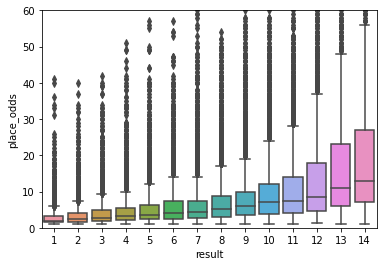

In [13]:
sns.boxplot(x='result', y='place_odds', data=runs_df)
plt.ylim(0,60)
plt.show()

#### Draw and Finish Position

The draw of a horse is random. Which horse begins the race in which stall is not determined by win odds or any other factor. It's a well-known fact in racing that the "inside" track is preferred since it reduces the overall distance traveled by the horse in the race. Therefore, it intuitively makes sense that a horse beginning the race inside (draw 1) would have a slightly better chance in the race than the outside (draw 14).

The chart below backs this up, to an extent. It is clear that the higher draw a horse has (the further from pole position they begin), the worse result they have on average.

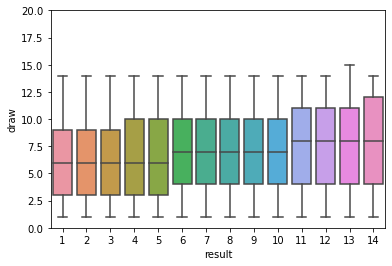

In [14]:
sns.boxplot(x='result', y='draw', data=runs_df)
plt.ylim(0,20)
plt.show()

#### Win Odds vs Result with Confidence Interval

Since it is clear there is a strong relationship between a horse's win or place odds and their result, we took another look at that relationship in another way.

The two plots below show the linear relationship between win odds and result, and place odds and result, with confidence intervals. Note how small he intervals. As the odds for a horse get worse, the interval gets larger, but only slightly.

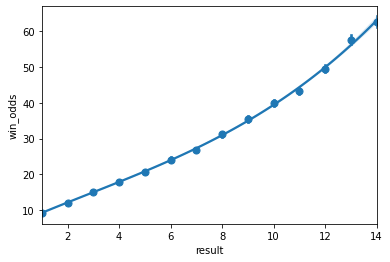

In [15]:
sns.regplot(x="result", y="win_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Place Odds vs Result with Confidence Interval

Refer to the description above.

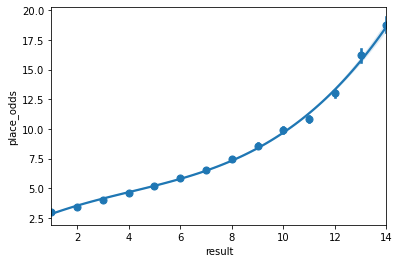

In [16]:
sns.regplot(x="result", y="place_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Draw vs Result with Confidence Interval

Again, we plotted the linear relationship. This time between draw and result. We showed earlier there is a relationship between draw and result, but you could see it was not as strong as the relationship between win or place odds and result.

The confidence intervals for the below plot support the claim that the relationship is not as strong. The confidence intervals are not nearly as tight, meaning there is a wider distribution. So, the draw is an important feature in result, but it is not as much of a "sure thing" as win or place odds.

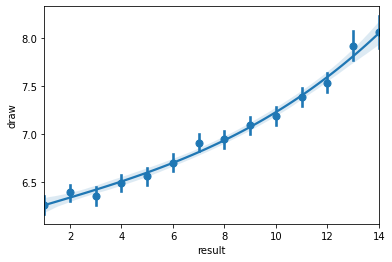

In [17]:
sns.regplot(x="result", y="draw", data=runs_df, x_estimator=np.mean, order=3)

#### Win Odds vs Place Odds, by Result

The last plot we chose to include in this report is a scatterplot showing win odds vs. place odds, categorized by result. The lighter the color, the better result, or finishing position. The darker the color, the worse the result.

It is clear, on the bottom-left of the graph the data points are lighter. In other words, a horse with lower win and place odds tends to finish the race in a better position. 

For this we filtered the data set for place odds of less than 30:1. There are a large number of outliers that make the plot less clear to read. We included the unfiltered plot below, for reference.

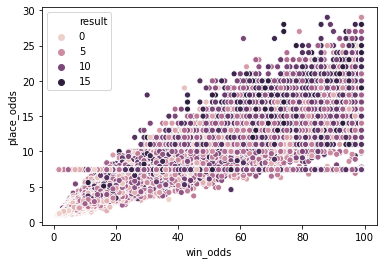

In [18]:
runs_df_lower_odds = runs_df[runs_df['place_odds'] < 30] 
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df_lower_odds)

#### Same plot but unfiltered for outliers

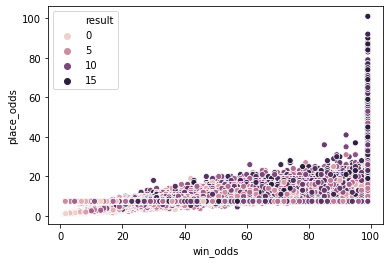

In [19]:
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df)

## Section 4: Modeling and Evaluation 1

Train and adjust parameters

### Section 4.1 K-Means Clustering

For the first K-means model, we used all parameters from the train data set. We put the model in a for-loop and incremented the number of clusters from 2 to 20. For each iteration we recorded the AUC and precision of the model to compare. 

Since we elected to use AUC as our primary metric, the model with the highest AUC is selected as the best number of clusters.


#### 4.1.1 KMeans Full - all features

In [20]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='full')
        
    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: Precision is: 0.604  AUC: 0.506  for clusters= 2
Found a better k: Precision is: 0.285  AUC: 0.511  for clusters= 3
Found a better k: Precision is: 0.325  AUC: 0.519  for clusters= 6
Found a better k: Precision is: 0.074  AUC: 0.521  for clusters= 13
Found a better k: Precision is: 0.077  AUC: 0.534  for clusters= 14
Best AUC: 0.534  for clusters= 14


#### 4.1.2 KMeans Elkan - all features

Next, we re-ran the same model as above but changed the sklearn KMeans algorithm parameter from the default (full) to "elkan". According to the sklearn documentation, elkan is best suited for data with well-defined clusters. For this model, we did not believe that to be the case but ran the model anyway. The model not only took longer to train but it did not typically achieve as high of an AUC score as the previous "full" model. Although there was some variability in results from run to run, even with n_init set to 10.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans


In [21]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='elkan')

    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    
print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: Precision is: 0.396  AUC: 0.494  for clusters= 2
Found a better k: Precision is: 0.285  AUC: 0.511  for clusters= 3
Found a better k: Precision is: 0.164  AUC: 0.520  for clusters= 5
Found a better k: Precision is: 0.084  AUC: 0.534  for clusters= 14
Found a better k: Precision is: 0.013  AUC: 0.540  for clusters= 18
Best AUC: 0.540  for clusters= 18


#### 4.1.3 KMeans and KMeans Mini Batch - Win and Place Odds

From the data exploration we performed in Section 3 of this report as well as previous reports, we know the most important features in the data set for predicting winners and losers to be Win Odds and Place Odds.

For this K-means model, we ran with only those predictors included in the training data to visualize the clustering and compare the performance to the previous models.

In [22]:
win_place_train=X_train[:,[6,7]] # Create an array with win odds, place odds
win_place_test=X_test[:,[6,7]]

In [23]:
best_auc_cluster = 0
best_auc = 0
auc_plot_KMeans = []
auc_plot_KMeansMini = []

for x in range(2,20):

    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train)
    kmeans_mini.fit(win_place_train)

    yhat= kmeans.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    auc_plot_KMeans.append(auc)
    
    yhat= kmeans_mini.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')
    auc_plot_KMeansMini.append(auc)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.727  AUC: 0.401  for clusters= 2
Found a better k: KMeans Mini Precision is: 0.432  AUC: 0.662  for clusters= 2

Found a better k: KMeans Precision is: 0.216  AUC: 0.688  for clusters= 5
Found a better k: KMeans Mini Precision is: 0.090  AUC: 0.702  for clusters= 7

Best AUC: 0.702  for clusters= 7


#### 4.1.3.1 KMeans and KMeans Mini Batch - Visualize Number of Cluster Performance

In the above models, the AUC scores were saved off so we could plot them.

The first plot is for the K-Means model and the second is for the K-Means Mini-Batch model, which performed better than the regular K-Means.

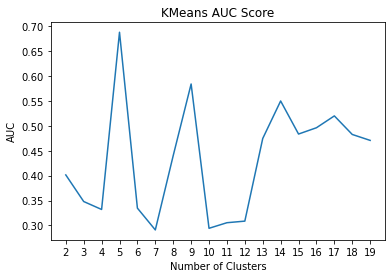

In [24]:
plt.plot(auc_plot_KMeans)
plt.title('KMeans AUC Score')
plt.xlabel('Number of Clusters')
plt.ylabel('AUC')
plt.xticks(np.arange(len(auc_plot_KMeans)), np.arange(2, len(auc_plot_KMeans)+2))

plt.show()

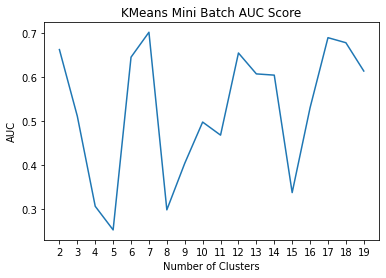

In [25]:
plt.plot(auc_plot_KMeansMini)
plt.title('KMeans Mini Batch AUC Score')
plt.xlabel('Number of Clusters')
plt.ylabel('AUC')
plt.xticks(np.arange(len(auc_plot_KMeansMini)), np.arange(2, len(auc_plot_KMeans)+2))

plt.show()

As can be seen above, in either K-Means or K-Means Mini-Batch there is no clear answer to how many clusters should be used. In both plots, a lower cluster value appears to perform better: they have higher AUC values.

#### 4.1.3.2 KMeans and KMeans Mini Batch - Silhouette Score

Due to the underwhelming visual above, we looked at another metric to attempt to judge the ideal number of clusters. We used Silhouette Score from the sklearn metric library. From the sklearn manual, "the Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample." It is a value between 1 and -1, with higher values indicating more well-defined clusters.

Source: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [26]:
# Note: this code block takes a while to execute so we only run for k = 2 to 10

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = KMeans(n_clusters = k).fit(win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

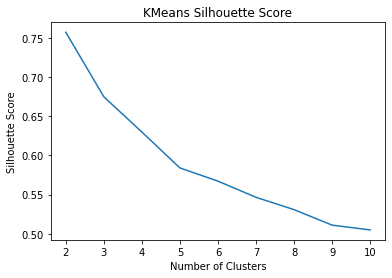

In [27]:
# Plot the above

plt.plot(sil)
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

The Silhouette Score plot supports our claim that a lower number of clusters is better. There is a steep drop in performance as you increase the number of clusters.

#### 4.1.3.3 KMeans and KMeans Mini Batch - Plot the Clusters

After running the above models for all numbers of clusters from 2 to 20, we determined the number of clusters that produced the best AUC to be 4.

With that determination, we re-ran the K-Means model and plotted the results so we could visualize the clustering. If you recall the Win Odds vs Place Odds scatterplot from Section 3 Data Understanding, the below will look very familiar. Instead of coloring each point based on Result (place the horse finished) as we did in Section 3, here the data points are colored by the cluster they were assigned to.

We plot both the results from K-Means and K-Means Mini-Batch. Recall that K-Means Mini-Batch performed better in general.


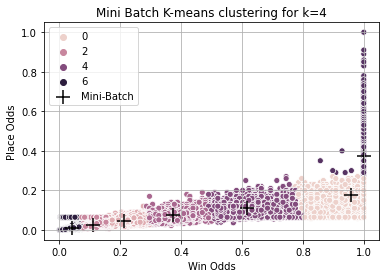

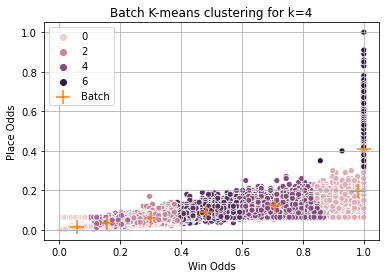

In [28]:
kmeans_mini = MiniBatchKMeans(n_clusters=best_auc_cluster, batch_size=10,random_state=0)
kmeans = KMeans(n_clusters=best_auc_cluster,random_state=0)

kmeans.fit(win_place_train)
kmeans_mini.fit(win_place_train)
    
c_mini=kmeans_mini.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_mini)
centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')
plt.legend()
plt.title('Mini Batch K-means clustering for k=4')
plt.xlabel('Win Odds')
plt.ylabel('Place Odds')
plt.grid()
plt.show()

c_means=kmeans.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_means)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')
plt.legend()
plt.title('Batch K-means clustering for k=4')
plt.xlabel('Win Odds')
plt.ylabel('Place Odds')
plt.grid()
plt.show()

#### 4.1.4 K-Means and K-Means Mini Batch - Win and Place Odds Filtered

As we discussed in Section 3, if we filter the Place Odds for only those with odds of less than 30:1, the data plots much cleaner. Next, we filtered the data similarly and created models with it to compare to the unfiltered model.

In terms of model deployment, this is not very useful. If you are gambling, the most money is to be made on bets with longer odds. Additionally, we do not have a statistical reason to filter out these "outliers".

In [29]:
# Filter the place odds
runs_data_sub = runs_df_lower_odds.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show','horse_no','horse_age','horse_country','horse_type','horse_rating','declared_weight','actual_weight'], axis=1)
runs_target_sub = runs_df_lower_odds['won']

X_train_sub,X_test_sub,Y_train_sub,Y_test_sub = train_test_split(runs_data_sub,runs_target_sub,test_size=0.20,random_state=0)

mmscl_obj = MinMaxScaler()
X_train_sub = mmscl_obj.fit_transform(X_train_sub,y = None)
X_test_sub = mmscl_obj.transform(X_test_sub)

win_place_train_odds_sub=X_train_sub[:,[1,2]] # Create an array with win odds, place odds
win_place_test_odds_sub=X_test_sub[:,[1,2]]

In [30]:
# Re-run the models
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train_odds_sub)
    kmeans_mini.fit(win_place_train_odds_sub)

    yhat= kmeans.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

    yhat= kmeans_mini.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.745  AUC: 0.414  for clusters= 2
Found a better k: KMeans Mini Precision is: 0.255  AUC: 0.586  for clusters= 2

Found a better k: KMeans Precision is: 0.102  AUC: 0.595  for clusters= 7
Found a better k: KMeans Mini Precision is: 0.115  AUC: 0.620  for clusters= 10

Found a better k: KMeans Mini Precision is: 0.098  AUC: 0.645  for clusters= 15

Found a better k: KMeans Precision is: 0.091  AUC: 0.672  for clusters= 16
Best AUC: 0.672  for clusters= 16


Surprisingly, this model performed worse than the unfiltered model. This is most likely because observations with Place Odds of greater than 30:1 make up a large part of the data set, therefore we had less to train on. However, one would have thought removing more "extreme" points would have made up for that.

Since the model performed comparatively poor and is not useful in model deployment, we do not show the plots here.


#### 4.1.5 KMeans and KMeans Mini Batch - Win Odds, Place Odds, and Draw

For the next KMeans model, we added the “draw” feature into the predictors. Our data exploration in this lab and previous labs showed the three most significant features for predicting wins and losses are: win odds, place odds, and draw.

We start by creating another Silhouette Score plot.


In [31]:
draw_win_place_train=X_train[:,[5,6,7]] # Create an array with win odds, place odds, draw

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = KMeans(n_clusters = k).fit(draw_win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

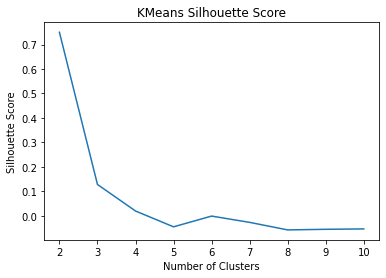

In [32]:
plt.plot(sil)
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

The Silhouette Score plot above suggests the number of clusters for this model (win odds, place odds, and draw) will be similar to previous models (win odds and place odds), but with a quicker drop off in performance when increasing the number of clusters.

We run K-Means and K-Means Mini-Batch for all numbers of clusters from 2 to 20 and compare the AUC.


In [33]:
draw_win_place_test=X_test[:,[5,6,7]] # Create an array with win odds, place odds, draw

best_auc_cluster = 0
best_auc = 0
auc_plot_KMeans = []
auc_plot_KMeansMini = []

for x in range(2,20):

    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(draw_win_place_train)
    kmeans_mini.fit(draw_win_place_train)

    yhat= kmeans.predict(draw_win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    auc_plot_KMeans.append(auc)
    
    yhat= kmeans_mini.predict(draw_win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
        print('')
    auc_plot_KMeansMini.append(auc)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: KMeans Precision is: 0.278  AUC: 0.600  for clusters= 2
Best AUC: 0.600  for clusters= 2


As the Silhouette Score indicated, lower numbers of clusters give better AUC scores with two clusters providing the best score. This confirms our intuition from the Silhouette Score plot.

We make a final K-Means model using this number of clusters and plot the results in three dimensions.

#### 4.1.5.1 KMeans Mini Batch - Win Odds, Place Odds, and Draw

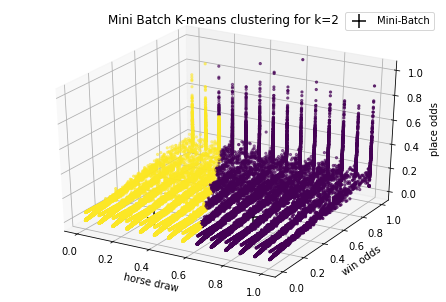

In [34]:
# visualize the model with best number of clusters
kmeans_mini = MiniBatchKMeans(n_clusters=best_auc_cluster, batch_size=10,random_state=0)
kmeans_mini.fit(draw_win_place_train)

fig = plt.figure()
ax = Axes3D(fig)

c_mini=kmeans_mini.labels_
ax.scatter(draw_win_place_train[:,0], draw_win_place_train[:,1], draw_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans_mini.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch',depthshade=False)  # plot the centroids
ax.legend()
plt.title('Mini Batch K-means clustering for k=2')
plt.xlabel('horse draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

#### 4.1.4 K-Means Summary

For Section 4.1 we generated several K-Means models.

First, we used all predictors. Second, we used the place and win odds predictors. We made a variation of this model where we filtered out more "extreme" place odds although it does not provide much practical benefit. Lastly, we used place odds, win odds, and draw. Our data exploration in Section 3 led us to select these predictors to focus on.

For the models, we varied several parameters. We tried "full" and "Elkan" versions of the model. Compared the performance for all numbers of clusters from 2 to 20. We used K-Means and K-Means Mini-Batch.

The model with the best AUC was the K-Means Mini-Bath with k=4 and place odds and win odds for predictors (Section 4.1.3.3). We achieved an AUC of 0.713. The K-Means Mini-Bath with k=4 for place odds, win odds, and the addition of draw, was only able to achieve an AUC of 0.600 (Section 4.1.5.1).


### Sub-Section 4.2 DBSCAN

DBSCAN is a density based clustering algorithm. Our team will compare 3 Random Forest classification models to predict 'Won'. The first is a reference model that was found to be the best model from Lab 2 and does not use clustering. The second will use a DBSCAN cluster of manually selected attributes and include this in the model along with the other key attributes. The third model will use a DBSCAN cluster of the top 3 Principal Components and include this in the model along with the other key attributes. Our focus is on maximizing precision and our secondar metric of importance is AUC. The reason we are limiting each of these methods to 3 features is that it will allow us to visualize our results. DBSCAN is capable of clustering in higher dimensions even though that may not be a strength of the algorithm.

#### Sub-Section 4.2.1 Base Random Forest Model (from Lab 2) for Reference

This model and associated parameters were optimized in Lab 2 to predict won achieved the highest precision and AUC. We will select the balanced option, use 64 trees, and have a maximum tree depth of 100.

#### Look at Random Forest model example without clustering with all variables included (parameters optimized based on Lab 2 investigation)

Random Forest without clustering with all variables:
   Precision:  0.46153846153846156
   AUC:  0.5085741745987077


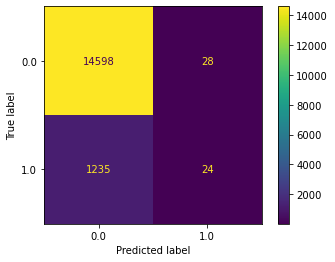

In [35]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(X_train, Y_train)
yhat=rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest without clustering with all variables:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, X_test, Y_test)

The random forest model using no clusters and all the features results in a Precision of 0.46 and an AUC of 0.51.

#### Sub-Section 4.2.2 DBSCAN Cluster With Manual Feature Selection

Next, we will use the visuals from the data understanding section and domain knowledge to select draw, win odds, and place odds as the three most influential features in predicting won. We will use DBSCAN to cluster these features and use the clusters as an additional attribute to predict Won.

#### Find specified nearest neighbor distance to find appropriate value for EPS

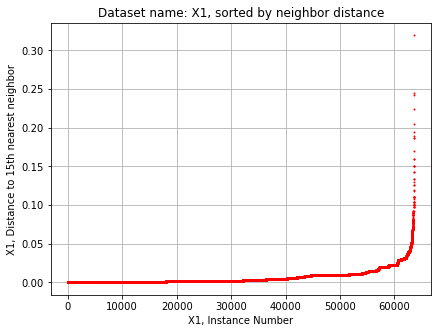

In [36]:
draw_win_place_train=X_train[:,[5,6,7]] #Create an array with win odds, place odds, and horse age
X1=draw_win_place_train

#=======================================================
# CHANGE THIS VALUES TO ADJUST MINPTS FOR THE DATASET
X1_N = 15
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X1_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

This plot shows the sorted distance of the 15th nearest neighbor for each instance of the data set with draw, win odds, and place odds. Setting the eps parameter based on the distance at the elbow of the chart above, we used an eps of .029 and min points of 15 for our DBSCAN model.

#### Find clusters based on training data using DBSCAN

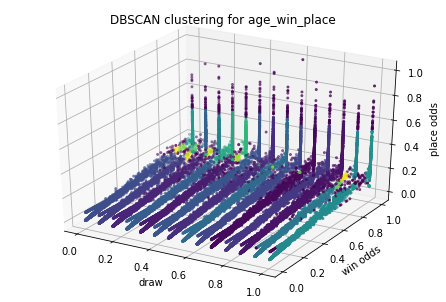

number of clusters found:  39


In [37]:
X=X1
X_minpts = 15 # from above
X_eps = 0.029

model = DBSCAN(eps=X_eps, min_samples=X_minpts)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=4,depthshade=True)
plt.title('DBSCAN clustering for age_win_place')
plt.xlabel('draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of clusters found: ", len(set(model.labels_)))

In [38]:
silhouette_score(X,pred,random_state=0)

-0.02556027740584741

A visual of the clustered data from the training set is shown above. The model sorted the data into 39 clusters. Many of the clusters appear to make sense visually. In addition to visual verification, we will use the silhouette score which uses a scale from -1 (worst) to 1 (best) to describe the intra-cluster distance. When looking at the silhouette score, we have a value near zero that drifts slightly negative. This is an indicator there are overlapping clusters which is not ideal.

Further information on the silhouette score can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

#### Find clusters for test data using KNN

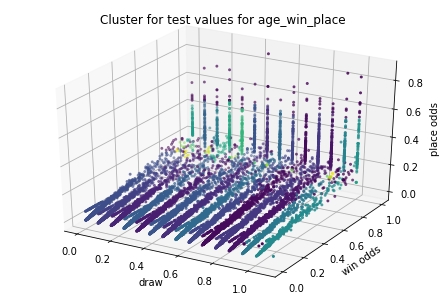

number of cluster found:  39


In [39]:
X1_test=X_test[:,[5,6,7]]

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X1,model.labels_)
y_pred=neigh.predict(X1_test)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X1_test[:,0], X1_test[:,1], X1_test[:,2], c=y_pred, s=4,depthshade=True)
plt.title('Cluster for test values for age_win_place')
plt.xlabel('draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of cluster found: ", len(set(y_pred)))

To prevent data leakage, the initial clusters were created with training data only. We were able to approximate the cluster each test data point belongs to by using KNN to predict the cluster value based on the training cluster values. Above, is a visual plot of the test data sorted into clusters. It appears to match the pattern from the training data, so we can be confident the KNN method to predict clusters for test points was effective.

#### Add one-hot encoded clusters to the training and test sets

We will now one-hot encode the clusters as they are a nominal attribute. This will allow us to use the clusters to predict Won.

In [40]:
one_hot_labels = np.zeros((model.labels_.size, model.labels_.max()+1))
one_hot_labels[np.arange(model.labels_.size),model.labels_] = 1
#print(one_hot_labels.shape)

one_hot_preds = np.zeros((y_pred.size, y_pred.max()+1))
one_hot_preds[np.arange(y_pred.size),y_pred] = 1
#print(one_hot_preds.shape)

new_xtrain=np.hstack((X_train, one_hot_labels))
new_xtest=np.hstack((X_test, one_hot_preds))

#### Predict Won with new cluster attributes

We now will use a random forest model that includes the cluster as an additional feature with the same parameters as the reference model. This will allow us to compare the impact of the cluster attribute on the model.

Random Forest with all variables and DBSCAN clustering attribute:
   Precision:  0.46296296296296297
   AUC:  0.5089371294897712


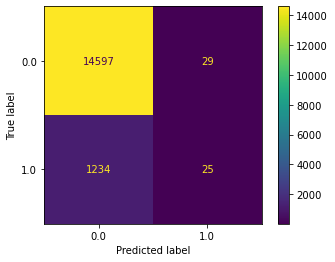

In [41]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(new_xtrain, Y_train)
yhat=rf.predict(new_xtest)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest with all variables and DBSCAN clustering attribute:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, new_xtest, Y_test)

The model has a the same Precision (.46) and AUC (.51) than the reference model so the additional attribute created by clustering the three most significant features draw, win odds, and place odds did not provide any significant additional value.

#### Sub-Section 4.2.3 DBSCAN Cluster With Feature Selection using PCA

Next, we will use PCA to identify the three principal components that describe the most variation. Using these three principal components, we will use DBSCAN to once again assign each point a cluster and use these values as an additional attribute to predict Won. We will compare a random forest model with the new attribute to the reference model using precision and AUC.

#### Identify Top 3 Principal Components

In [42]:
pca = PCA(n_components=3,random_state=0)
pca_X_train=X_train
pca_X_test=X_test
pca.fit_transform(X_train)
pca.transform(X_test)
print(pca.explained_variance_ratio_)

[0.31407038 0.15827638 0.11670845]


We use PCA on the training data set to fit and transform the test and training data sets. The model identified the top three principal components from the training data set. We can see from the output that these three components capture nearly 60% of the variation in the data set.

#### Find specified nearest neighbor distance to find appropriate value for EPS

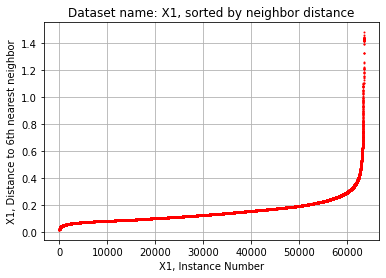

In [43]:
X1=pca_X_train

#=======================================================
# CHANGE THIS VALUES TO ADJUST MINPTS FOR THE DATASET
X1_N = 6
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X1_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)

plt.figure()
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

This plot shows the sorted distance of the 6th nearest neighbor for each instance of the data set with the top 3 principal components. Setting the eps parameter based on the distance at the elbow of the chart above, we used an eps of .31 and min points of 6 for our DBSCAN model.

#### Find clusters based on training data using DBSCAN

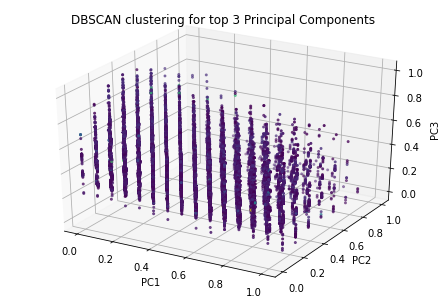

number of clusters found:  50


In [44]:
X=X1
X_minpts = 6 # from above
X_eps = 0.31

model = DBSCAN(eps=X_eps, min_samples=X_minpts)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=4,depthshade=True)
plt.title('DBSCAN clustering for top 3 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('PC3', rotation=90)
plt.show()

print("number of clusters found: ", len(set(model.labels_)))

In [45]:
silhouette_score(X,pred,random_state=0)

0.459709753380013

Our training data set with 3 principal components was divided into 50 clusters with the DBSCAN algorithm. The plot of the clusters is difficult to interpret, and this is likely due to the large amount of the identified noise points. The silhouette score of 0.45 is significantly better than 0 and indicates the clusters are well separated.

#### Find clusters for test data using KNN

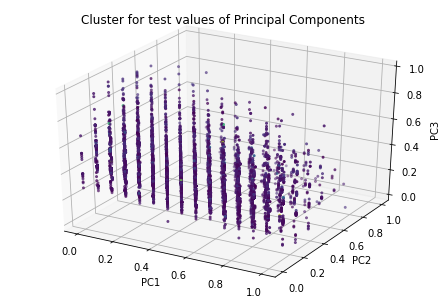

number of cluster found:  47


In [46]:
X1_test=pca_X_test

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X1,model.labels_)
y_pred=neigh.predict(X1_test)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X1_test[:,0], X1_test[:,1], X1_test[:,2], c=y_pred, s=4,depthshade=True)
plt.title('Cluster for test values of Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('PC3', rotation=90)
plt.show()

print("number of cluster found: ", len(set(y_pred)))

We predict the clusters of the test data for the principal components using KNN, and the predicted clusters are plotted above. The plot is difficult to see if the clusters align with the training data. 47 of the 50 clusters appear in the test data. We will assume the cluster predictions are sensible based on the methodology of using KNN.

#### Add one-hot encoded clusters to the training and test sets

We will now one-hot encode the clusters as they are a nominal attribute. This will allow us to use the clusters to predict Won.

In [47]:
one_hot_labels = np.zeros((model.labels_.size, model.labels_.max()+1))
one_hot_labels[np.arange(model.labels_.size),model.labels_] = 1
#print(one_hot_labels.shape)

one_hot_preds = np.zeros((y_pred.size, y_pred.max()+1))
one_hot_preds[np.arange(y_pred.size),y_pred] = 1
#print(one_hot_preds.shape)

new_xtrain=np.hstack((X_train, one_hot_labels))
new_xtest=np.hstack((X_test, one_hot_preds))

#### Predict Won with new cluster attributes

We now will use a random forest model that includes the cluster as an additional feature with the same parameters as the reference model. This will allow us to compare the impact of the cluster attribute on the model.

Random Forest with all variables and DBSCAN PCA clustering attribute:
   Precision:  0.5223880597014925
   AUC:  0.5128059782773385


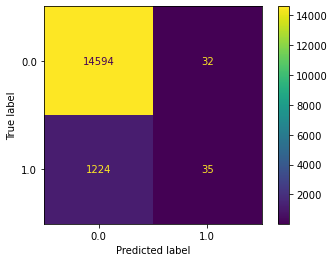

In [48]:
rf=RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
rf.fit(new_xtrain, Y_train)
yhat=rf.predict(new_xtest)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('Random Forest with all variables and DBSCAN PCA clustering attribute:')
print('   Precision: ',prec)
print('   AUC: ',auc)
plot_confusion_matrix(rf, new_xtest, Y_test)

The model has the highest precision at .52 and essentially an identical AUC to the reference model. Therefore, the additional attribute created by clustering the three top principal components did provide a significant additional value. We can see the model using DBSCAN clustering and PCA outperformed the model using DBSCAN and manual feature selection in our key metric precision. This aligns with what we saw in the silhouette score when comparing these models. The model using PCA had better intra-cluster seperation.

### Sub-Section 4.3 Spectral Clustering

In this section we will look at what spectral clustering is able to do with the data set. However, due to the computational requirements of spectral clustering, we were not able to run it on the full dataset, instead it will be run on a random subset of the train data. For this reason we are not going to be considering it for use in our final model, since we cannot accurately compare it to the other two models.

In [49]:
spec_test=X_test[:,[5,6,7]] # Create an array with win odds, place odds, draw

In [50]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,10):
    
    spc = SpectralClustering(
        n_clusters=x,      # number of clusters
        affinity = 'rbf')  # affinity select type
        
    
    yhat= spc.fit_predict(spec_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
        print('Found a better k: Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    
print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Found a better k: Precision is: 0.742  AUC: 0.410  for clusters= 2
Found a better k: Precision is: 0.100  AUC: 0.454  for clusters= 6
Found a better k: Precision is: 0.134  AUC: 0.462  for clusters= 9
Best AUC: 0.462  for clusters= 9


Here again we see the same pattern as with previous clustering that clusters 2 has the highest precision and a higher cluster number has the greatest AUC.

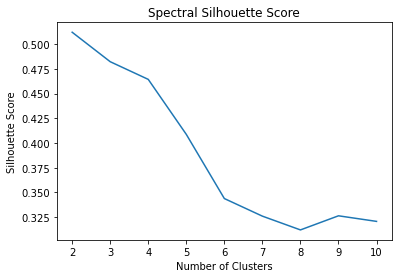

In [51]:
sil = []
kmax = 10

for k in range(2, kmax+1):
  spec_sil = SpectralClustering(n_clusters = k).fit_predict(spec_test)
  sil.append(silhouette_score(spec_test, spec_sil, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
plt.plot(sil)
plt.title('Spectral Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

Spectral Clustering ended up being a sad dead end for our team. We had hoped that it would provide some very useful clustering and data for the amount of computational power it required. However, we did not find it to be any more effective than any of the other types of clustering and it had a lot of barriers to overcome in order to utilize it. For this reason we decided to just compare K-means, mini batch K-means, and DBSCAN.

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

In looking at our entries for clustering comparison, the K-means clustering came out on top with a Silhouette score in the .75 range. This means that the clusters here were very defined when we had 2 clusters and limited our cluster variables to win odds, place odds, and draw. This is a substantially better score than what we saw with DBSCAN. We now want to see what effect adding these new variables to our current best model would have. Below is our base Random Forest model with no clustering added to it. We will use this and 10 kfold cross validation to compare this base to a data set with adding clustering.

### Base model to predict wins with no clustering

In [52]:
trees = [64]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 100, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.4395856679552332
   Mean AUC:  0.7466500753950618
   Mean Accuracy:  0.9193306863150135
   Mean Time per Split:  5.283132553100586
 


### Base model to predict show with no clustering

In [53]:
trees = [128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 100, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 128
   Mean Precision:  0.5680559282367552
   Mean AUC:  0.7478563135590329
   Mean Accuracy:  0.7735668403301501
   Mean Time per Split:  11.841953325271605
 


Now that we have this baseline to work with we will add in new columns for our created clusters from k-means to see if there is an increase in Precision and AUC that can be derived from adding in these new variables. For the sake of thoroughness, there will be a cluster_1 and a cluster_2 variable added. Cluster_1 will use the number of clusters that gave us the best precision while cluster_2 will use the number of clusters that gave the best AUC. In theory, Cluster_1 should be our main focus as it also had the best Silhouette Score.

In [54]:
#using our kmeans best model precision to cluster original dataset
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(runs_data)
predict = kmeans.labels_
print(predict)

[0 0 0 ... 1 1 0]


In [55]:
#merging clustered groups back onto original data set
runs_data['cluster_1'] = pd.Series(predict, index=runs_data.index)
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,cluster_1
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,1,0,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
#using our kmeans best model to cluster original dataset
kmeans_mini = MiniBatchKMeans(n_clusters=4, batch_size=10,random_state=0)
kmeans_mini.fit(runs_data)
predict = kmeans_mini.labels_
print(predict)

[2 2 1 ... 0 3 0]


In [57]:
#merging clustered groups back onto original data set
runs_data['cluster_2'] = pd.Series(predict, index=runs_data.index)
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,cluster_1,cluster_2
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,1,0,0,0,0,0,0,2
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,1,0,0,0,0,0,0,2
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,1,0,0,0,0,0,0,2


Now that we have our two new categories we will need to create dummy variables for them since these are categorical and not continuous. We are also going to split to two different data sets to be able to test each cluster independently as well as both together.

In [58]:
tmp_df = pd.get_dummies(runs_data.cluster_1,prefix='cluster_1_group')
cluster1df = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe
cluster1df = cluster1df.drop(['cluster_1','cluster_2'],axis = 1)

fulldf = pd.concat((runs_data,tmp_df),axis=1)

tmp_df = pd.get_dummies(runs_data.cluster_2,prefix='cluster_2_group')
cluster2df = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe
cluster2df = cluster2df.drop(['cluster_1','cluster_2'],axis = 1)

fulldf = pd.concat((fulldf,tmp_df),axis=1)
fulldf=fulldf.drop(['cluster_1','cluster_2'],axis = 1)
fulldf.head()

runs_data = runs_data.drop(['cluster_1','cluster_2'],axis = 1)

We will now test all three data sets against our control model from above.

### Wins Random Forest Models

Prec of .439 and AUC of .746 are the levels to beat .

In [59]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster1df, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.3881883965707495
   Mean AUC:  0.7466100121212211
   Mean Accuracy:  0.9188900198096783
   Mean Time per Split:  4.865004968643189
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.3881883965707495
   Mean AUC:  0.7466100121212211
   Mean Accuracy:  0.9188900198096783
   Mean Time per Split:  4.87188150882721
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.3814675197690223
   Mean AUC:  0.7487110927387203
   Mean Accuracy:  0.9188018839722828
   Mean Time per Split:  5.652992844581604
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.3814675197690223
   Mean AUC:  0.7487110927387203
   Mean Accuracy:  0.9188018839722828
   Mean Time per Split:  5.669797039031982
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.3849026592480773
   Mean AUC:  0.7522586423829039
   Mean Accuracy:  0.9190033334651169
   Mean Time per Split:  7.476387119293213
 
When Trees = 100 and Max_Depth= None
   Mean Pre

This first run looking at only the cluster 1 groupings seems to have lowered our precision, but the mean AUC is actually slightly higher than what we saw in the control group.

In [60]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster2df, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.3812967227392698
   Mean AUC:  0.7484647543054652
   Mean Accuracy:  0.9188396451511276
   Mean Time per Split:  5.276473498344421
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.3812967227392698
   Mean AUC:  0.7484647543054652
   Mean Accuracy:  0.9188396451511276
   Mean Time per Split:  5.2632804155349735
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.4047613275249574
   Mean AUC:  0.7504598122621056
   Mean Accuracy:  0.9189781477210468
   Mean Time per Split:  6.12405605316162
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.4047613275249574
   Mean AUC:  0.7504598122621056
   Mean Accuracy:  0.9189781477210468
   Mean Time per Split:  6.5742939710617065
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.40093912007145904
   Mean AUC:  0.7530855282241016
   Mean Accuracy:  0.9190159152407137
   Mean Time per Split:  8.304832243919373
 
When Trees = 100 and Max_Depth= None
   Mean 

After this run we are yet again seeing similar scores to the first run. This would indicate that cluster 1 and 2 by themselves are not enough to improve the overall model.

In [61]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, fulldf, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.41914499807775896
   Mean AUC:  0.7458983551812285
   Mean Accuracy:  0.9192425393811796
   Mean Time per Split:  5.212296724319458
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.41914499807775896
   Mean AUC:  0.7458983551812285
   Mean Accuracy:  0.9192425393811796
   Mean Time per Split:  5.209182476997376
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.40194946319307057
   Mean AUC:  0.7477283090261574
   Mean Accuracy:  0.9190159136555082
   Mean Time per Split:  6.140215039253235
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.40194946319307057
   Mean AUC:  0.7477283090261574
   Mean Accuracy:  0.9190159136555082
   Mean Time per Split:  6.160004878044129
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.4021286164335359
   Mean AUC:  0.751215073000378
   Mean Accuracy:  0.9191669964158187
   Mean Time per Split:  8.215858316421508
 
When Trees = 100 and Max_Depth= None
   Mean

This final model with both cluster variables in it does have a higher AUC score but a lower precision. Neither one of these difference is significant, so in this case we can really use either model. Thought the runtime is shorter with the control model.

### Place Random Forest Models

Prec of .568 and AUC of .747 are the levels to beat .

In [62]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster1df, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.5568054969698499
   Mean AUC:  0.7426867220394986
   Mean Accuracy:  0.7711997751037335
   Mean Time per Split:  5.727601361274719
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.5568054969698499
   Mean AUC:  0.7426867220394986
   Mean Accuracy:  0.7711997751037335
   Mean Time per Split:  5.813565397262574
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.5547011898358898
   Mean AUC:  0.7439203960185239
   Mean Accuracy:  0.7713130840035556
   Mean Time per Split:  6.690073609352112
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.5547011898358898
   Mean AUC:  0.7439203960185239
   Mean Accuracy:  0.7713130840035556
   Mean Time per Split:  6.817278122901917
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.562050669235225
   Mean AUC:  0.7457739025284594
   Mean Accuracy:  0.7721818510906832
   Mean Time per Split:  9.139843630790711
 
When Trees = 100 and Max_Depth= None
   Mean Pre

This was exciting that this model manage to beat, if barely, the control model. The results here are not significantly different, but the fact that at least the precision was slightly higher.

In [63]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster2df, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.5565970340455171
   Mean AUC:  0.7430754621341642
   Mean Accuracy:  0.7710864360850079
   Mean Time per Split:  6.246498036384583
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.5565970340455171
   Mean AUC:  0.7430754621341642
   Mean Accuracy:  0.7710864360850079
   Mean Time per Split:  6.2322211265563965
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.5532717111374895
   Mean AUC:  0.744105356427241
   Mean Accuracy:  0.7709101596546002
   Mean Time per Split:  7.325176239013672
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.5532717111374895
   Mean AUC:  0.744105356427241
   Mean Accuracy:  0.7709101596546002
   Mean Time per Split:  7.335053157806396
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.5610928213244977
   Mean AUC:  0.7458682214825153
   Mean Accuracy:  0.7718922657604532
   Mean Time per Split:  9.67896933555603
 
When Trees = 100 and Max_Depth= None
   Mean Prec

This particular set of clustering is again within a shout of our original control model, however, it did not manage to beat either precision or AUC.

In [64]:
trees = [64,75,100,128]
depth = [100,None]
for x in trees:
    for y in depth:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', RandomForestClassifier(max_depth = y, n_estimators = x, random_state = 0, class_weight = 'balanced')))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, fulldf, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When Trees =',x,'and Max_Depth=',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When Trees = 64 and Max_Depth= 100
   Mean Precision:  0.556120727210277
   Mean AUC:  0.7424997527671832
   Mean Accuracy:  0.7710864281589807
   Mean Time per Split:  6.197676849365234
 
When Trees = 64 and Max_Depth= None
   Mean Precision:  0.556120727210277
   Mean AUC:  0.7424997527671832
   Mean Accuracy:  0.7710864281589807
   Mean Time per Split:  6.1337950229644775
 
When Trees = 75 and Max_Depth= 100
   Mean Precision:  0.5549295794377885
   Mean AUC:  0.7434714190429791
   Mean Accuracy:  0.7712878538737332
   Mean Time per Split:  7.179010796546937
 
When Trees = 75 and Max_Depth= None
   Mean Precision:  0.5549295794377885
   Mean AUC:  0.7434714190429791
   Mean Accuracy:  0.7712878538737332
   Mean Time per Split:  7.2499041795730585
 
When Trees = 100 and Max_Depth= 100
   Mean Precision:  0.5568767548195193
   Mean AUC:  0.7452935074122783
   Mean Accuracy:  0.7711745972856908
   Mean Time per Split:  9.625231218338012
 
When Trees = 100 and Max_Depth= None
   Mean Pr

Using both categories actually created a situation where our model seems to have been confused and performed worse than the control model. This was unexpected as the data had increased or kept the same statistics in every other model we ran.

### Exceptional work, Adaboost comparison
In this section we wanted one more attempt at trying to get our models to achieve the highest precision we could before deciding on a final grouping. First we want to see what a standard Adaboost model would do with the same data as our control model, then see if it can utilize the clustering data we created to greater effect than the random forest model.

In [65]:
estimators = [64,75,100,128]
rate = [.25,.5,.75,1]
for x in estimators:
    for y in rate:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', AdaBoostClassifier(n_estimators=x, learning_rate = y, random_state=0)))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When estimators =',x,'and learning rate =',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When estimators = 64 and learning rate = 0.25
   Mean Precision:  0.5100595238095238
   Mean AUC:  0.7868497816079335
   Mean Accuracy:  0.919972797557566
   Mean Time per Split:  3.5405398845672607
 
When estimators = 64 and learning rate = 0.5
   Mean Precision:  0.6041960753086074
   Mean AUC:  0.7849961666789954
   Mean Accuracy:  0.920388302096913
   Mean Time per Split:  3.555681586265564
 
When estimators = 64 and learning rate = 0.75
   Mean Precision:  0.4961658672922975
   Mean AUC:  0.785588642716515
   Mean Accuracy:  0.9199979722051982
   Mean Time per Split:  3.512482237815857
 
When estimators = 64 and learning rate = 1
   Mean Precision:  0.531950843778647
   Mean AUC:  0.7847635208376188
   Mean Accuracy:  0.9201616589339816
   Mean Time per Split:  3.520195484161377
 
When estimators = 75 and learning rate = 0.25
   Mean Precision:  0.5073863636363636
   Mean AUC:  0.7868036236847816
   Mean Accuracy:  0.9199727959723607
   Mean Time per Split:  4.1027421951293945
 
W

There are two major take aways from this initial adaboost test. the first is that we see a swing in precision from .439 to .6 and a boost in AUC from .746 to .784. The second major item of note is the improved time per split. This makes this model extremely attractive. We will now run the same test but with adding in our three different clustering datasets, cluster_1 only, cluster_2 only, then both clusters.

In [66]:
estimators = [64,75,100,128]
rate = [.25,.5,.75,1]
for x in estimators:
    for y in rate:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', AdaBoostClassifier(n_estimators=x, learning_rate = y, random_state=0)))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster1df, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When estimators =',x,'and learning rate =',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When estimators = 64 and learning rate = 0.25
   Mean Precision:  0.5100595238095238
   Mean AUC:  0.7868497816079335
   Mean Accuracy:  0.919972797557566
   Mean Time per Split:  3.6431185960769654
 
When estimators = 64 and learning rate = 0.5
   Mean Precision:  0.6041960753086074
   Mean AUC:  0.7849961666789954
   Mean Accuracy:  0.920388302096913
   Mean Time per Split:  3.649962329864502
 
When estimators = 64 and learning rate = 0.75
   Mean Precision:  0.4961658672922975
   Mean AUC:  0.785588642716515
   Mean Accuracy:  0.9199979722051982
   Mean Time per Split:  3.669214200973511
 
When estimators = 64 and learning rate = 1
   Mean Precision:  0.531950843778647
   Mean AUC:  0.7847635208376188
   Mean Accuracy:  0.9201616589339816
   Mean Time per Split:  3.639763116836548
 
When estimators = 75 and learning rate = 0.25
   Mean Precision:  0.5073863636363636
   Mean AUC:  0.7868036236847816
   Mean Accuracy:  0.9199727959723607
   Mean Time per Split:  4.251008033752441
 
Wh

These results came back as nearly identical to our model that is not useing clustering. So we will ignore this set since it provides no advantage.

In [67]:
estimators = [64,75,100,128]
rate = [.25,.5,.75,1]
for x in estimators:
    for y in rate:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', AdaBoostClassifier(n_estimators=x, learning_rate = y, random_state=0)))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, cluster2df, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When estimators =',x,'and learning rate =',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When estimators = 64 and learning rate = 0.25
   Mean Precision:  0.5100595238095238
   Mean AUC:  0.7868677516747521
   Mean Accuracy:  0.919972797557566
   Mean Time per Split:  3.7707075595855715
 
When estimators = 64 and learning rate = 0.5
   Mean Precision:  0.6041960753086074
   Mean AUC:  0.7849961666789954
   Mean Accuracy:  0.920388302096913
   Mean Time per Split:  3.7348167657852174
 
When estimators = 64 and learning rate = 0.75
   Mean Precision:  0.4961658672922975
   Mean AUC:  0.785588642716515
   Mean Accuracy:  0.9199979722051982
   Mean Time per Split:  3.732168769836426
 
When estimators = 64 and learning rate = 1
   Mean Precision:  0.531950843778647
   Mean AUC:  0.7847635208376188
   Mean Accuracy:  0.9201616589339816
   Mean Time per Split:  3.710627126693726
 
When estimators = 75 and learning rate = 0.25
   Mean Precision:  0.5245292207792207
   Mean AUC:  0.786810530341681
   Mean Accuracy:  0.9199979753756088
   Mean Time per Split:  4.353525567054748
 
Wh

This was the second set of results that showed the same results as our first Adaboost model. We ran them again just to make sure it wasn't an error but due to the fact that the scores are identical it looks like the model is not finding the clustering significant, hence the lack of change in the model.

In [68]:
estimators = [64,75,100,128]
rate = [.25,.5,.75,1]
for x in estimators:
    for y in rate:
        # define the pipeline
        steps = list()
        steps.append(('scaler', MinMaxScaler()))
        steps.append(('model', AdaBoostClassifier(n_estimators=x, learning_rate = y, random_state=0)))
        pipeline = Pipeline(steps=steps)

        #Modeling with pipeline and scoring with cross_validate()
        scores = cross_validate(pipeline, fulldf, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
        print('When estimators =',x,'and learning rate =',y)
        print('   Mean Precision: ',np.mean(scores['test_precision']))
        print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
        print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
        print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
        print(' ')

When estimators = 64 and learning rate = 0.25
   Mean Precision:  0.5100595238095238
   Mean AUC:  0.7868677516747521
   Mean Accuracy:  0.919972797557566
   Mean Time per Split:  3.9951425313949587
 
When estimators = 64 and learning rate = 0.5
   Mean Precision:  0.6041960753086074
   Mean AUC:  0.7849961666789954
   Mean Accuracy:  0.920388302096913
   Mean Time per Split:  3.8987523317337036
 
When estimators = 64 and learning rate = 0.75
   Mean Precision:  0.4961658672922975
   Mean AUC:  0.785588642716515
   Mean Accuracy:  0.9199979722051982
   Mean Time per Split:  3.8702568769454957
 
When estimators = 64 and learning rate = 1
   Mean Precision:  0.531950843778647
   Mean AUC:  0.7847635208376188
   Mean Accuracy:  0.9201616589339816
   Mean Time per Split:  3.9451479196548465
 
When estimators = 75 and learning rate = 0.25
   Mean Precision:  0.5245292207792207
   Mean AUC:  0.786810530341681
   Mean Accuracy:  0.9199979753756088
   Mean Time per Split:  4.50103268623352
 
W

Yet again it doesn't look like our clustering was deemed significant by the adaboost model. However, this does not mean that the clustering overall was not useful in visualizing or noting additional infomation about our dataset. More will be explored in the ramifications section.

## Section 6: Modeling and Evaluation 3

Visualize Results

We wanted here to point out a visualization of our two clustering groups the first is a visualization of what cluster 1 would look like. The second below that is what cluster 2 looks like.

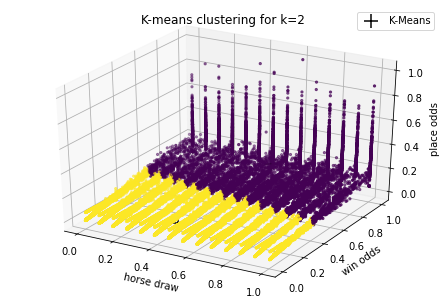

In [69]:
# visualize the model with best number of clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(draw_win_place_train)

fig = plt.figure()
ax = Axes3D(fig)

c_mini=kmeans.labels_
ax.scatter(draw_win_place_train[:,0], draw_win_place_train[:,1], draw_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='K-Means',depthshade=False)  # plot the centroids
ax.legend()
plt.title('K-means clustering for k=2')
plt.xlabel('horse draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

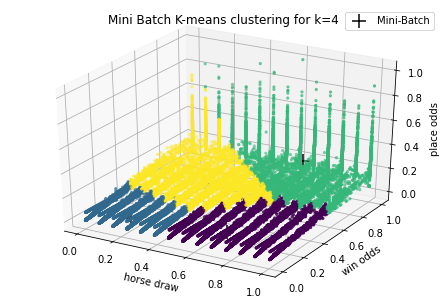

In [70]:
# visualize the model with best number of clusters
kmeans_mini = MiniBatchKMeans(n_clusters=4, batch_size=10,random_state=0)
kmeans_mini.fit(draw_win_place_train)

fig = plt.figure()
ax = Axes3D(fig)

c_mini=kmeans_mini.labels_
ax.scatter(draw_win_place_train[:,0], draw_win_place_train[:,1], draw_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans_mini.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch',depthshade=False)  # plot the centroids
ax.legend()
plt.title('Mini Batch K-means clustering for k=4')
plt.xlabel('horse draw')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

Below is a visualization of how we determined the best clustering. This chart shows the Silhouette scores charted with different numbers of clusters. Silhouette scores help indicate how distinct each cluster is. Having more distinct clusters is better because that means there is limited overlap. This means the clusters will be more descriptive in helping to classify the data. 


In [71]:
draw_win_place_train=X_train[:,[5,6,7]] # Create an array with win odds, place odds, draw

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = KMeans(n_clusters = k).fit(draw_win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

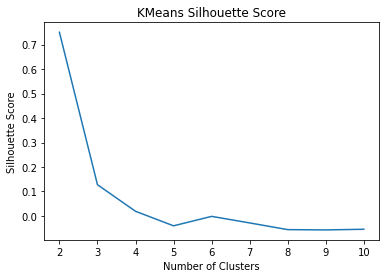

In [72]:
plt.plot(sil)
plt.title('KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

Here we can see that the clusters are most distinct when split into 2 clusters for the k-means.

In [73]:
draw_win_place_train=X_train[:,[5,6,7]] # Create an array with win odds, place odds, draw

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans_sil = MiniBatchKMeans(n_clusters=k, batch_size=10,random_state=0).fit(draw_win_place_train)
  labels = kmeans_sil.labels_
  sil.append(silhouette_score(win_place_train, labels, metric = 'euclidean'))

# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

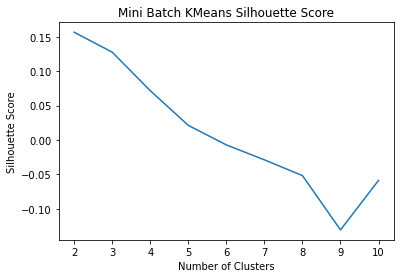

In [74]:
plt.plot(sil)
plt.title('Mini Batch KMeans Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(len(sil)), np.arange(2, len(sil)+2))

plt.show()

Here with the minibatch, we see that 2 clusters would have given the best silhouette score but we took the clustering with the best AUC for this grouping instead. Our final graphics are confusion matixes to show the difference between our previous best model and our new best model using adaboost.

#### Random Forest Model to predict Won

   Precision:  0.46153846153846156
   AUC:  0.5085741745987077
 


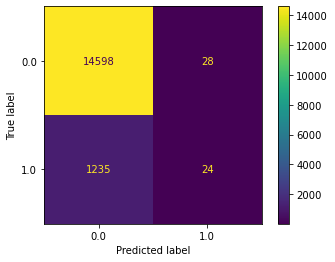

In [75]:
clf_rfw = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rfw.fit(X_train,Y_train.values.ravel())
yhat = clf_rfw.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('   Precision: ',prec)
print('   AUC: ',auc)
print(' ')
plot_confusion_matrix(clf_rfw, X_test, Y_test)

#### Adaboost Model to predict Won

   Precision:  0.7272727272727273
   AUC:  0.5061491352240621
 


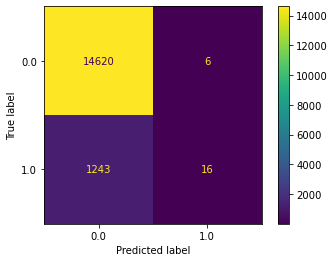

In [76]:
clf_ab = AdaBoostClassifier(n_estimators=64, learning_rate = .5, random_state=0)
clf_ab.fit(X_train,Y_train.values.ravel())
yhat = clf_ab.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
print('   Precision: ',prec)
print('   AUC: ',auc)
print(' ')
plot_confusion_matrix(clf_ab, X_test, Y_test)

#### Random Forest Model to predict place

   Precision:  0.5538366336633663
   AUC:  0.5917830310856639
 


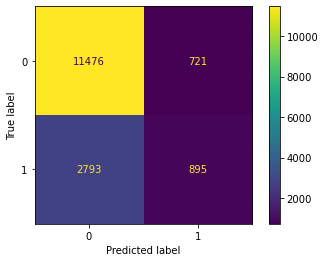

In [77]:
clf_rfw2 = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rfw2.fit(X_train_place,Y_train_place.values.ravel())
yhat = clf_rfw2.predict(X_test_place)
prec = mt.precision_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)
print('   Precision: ',prec)
print('   AUC: ',auc)
print(' ')
plot_confusion_matrix(clf_rfw2, X_test_place, Y_test_place)

#### Adaboost Model to predict place

   Precision:  0.6184886280264124
   AUC:  0.5929728706269473
 


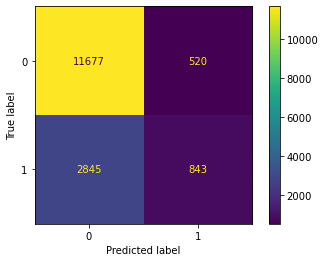

In [78]:
clf_ab2 = AdaBoostClassifier(n_estimators=64, learning_rate = .5, random_state=0)
clf_ab2.fit(X_train_place,Y_train_place.values.ravel())
yhat = clf_ab2.predict(X_test_place)
prec = mt.precision_score(Y_test_place,yhat)
auc = roc_auc_score(Y_test_place,yhat)
print('   Precision: ',prec)
print('   AUC: ',auc)
print(' ')
plot_confusion_matrix(clf_ab2, X_test_place, Y_test_place)

We can see that in the above two pairings of confusion matrixes that both the metrics we judged them on as well as the real world application of those metrics in the confusion matrixes support our moving from random forest as our main model to adaboost.

## Section 7: Modeling and Evaluation 4

There are a few ramifications of the work we did for this project. The first is a deeper understanding of the content data through our use of clustering. We believe had we had more time to go through more permutations of clusters we could have selected some that yielded greater benefits to the model. However, the data we did look at, did give us a better understanding of variable significance in our models. The second major ramification was a change in our machine learning model from random forest, which had previously been our best, to adaboost. This change jumped our precision anywhere from 20+% to 3% depending on cross validation or training test split. This is a huge jump that makes our model more effective for a client wishing to use it. It also reduced our number of false positives in both predicting for wins and placing. This means that a client wishing to use the model has confidence that when the model does predict a winner or placer that the model is more likely to give them an actual winner than a non-winner. For deploying these models, that is a crucial driving force in its acceptance by the users. We believe this model failed in its initial goal to be able to “beat the bookie”, however, because of its speed of prediction it could be carried on a laptop to a track, data input into it, and run day of before the race using, the current house odds and other data available to the track goer. Or it could be used by the house in conjunction with their experts to predict winners and placers for creating marketing to push gamblers away from those horses predicted to win. 

## Section 8: Deployment

### Sub-Section 8.1: How useful is your model for interested parties

The real life application of using a model to classify Won and Show would be to give a better an advantage over the average better. The models will give a better insight when to place a wager on a Won or Show outcome that the average better would not have. Based on class balance, a better should never bet on a horse to Win or Show because the probilities are much stronger that the events will not occur. The long term gain would be that betters following the model would have higher returns than the average better. This is accomplished by our model's focus on precision to ensure the highest success rate of positive predictions. We were able to ingore False Negatives because a better will not lose any money.

### Sub-Section 8.2: How would you measure the model's value if it was used by these parties? 

To measure the value of the model, we would need to look at the average better's success rate and money lost/earned over a specific period of time compared to the model's. The real value comes from the differential in expected money lost/earned to justify why someone might even pay to use this model.

### Sub-Section 8.3: How would your deploy your model for interested parties? 

As this dataset is publicly available, we would deploy this model to horse betters who are interested in a data-driven advantage. We could provide daily updates on horses predicted to Win or Show on a publicly available website. We then would consistently need to update and refine the model as more and more horse racing data is collected. If the model is successfull for betters, we could move to a subscription based service to gain the data-driven advantage.

### Sub-Section 8.4: What other data should be collected?

Since our dataset only includes data from two horse tracks in Hong Kong, it would be useful to also collect racing data from other parts of the world. With this data, we can extend our target audience to horse racing betters globally. 

### Sub-Section 8.5: How often would the model need to be updated? 

Once our model is deployed on the web, we would update the model on a daily basis to predict the horse races for the next 24 hours. This will be critical because you want to be sure to have the most up to date information on all the horses. We have to keep in mind that new horses will continually be added and older horses will eventually retire.

## Section 9: Exceptional Work

The exceptional work section can be found with the use of adaboost near the end of section 5. It is noted there as exceptional work.